# **Improving Pavement Crack Segmentation Using Attention and Self-gated Activation**

In [1]:
#Necessary Libraries
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf
from datetime import datetime
from PIL import Image
from keras import backend, optimizers
import random

In [2]:
# Necessary libraries for model
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Train Dataset**

In [4]:
# Load image and mask directories

image_directory = '/content/drive/MyDrive/Segmentation/Dataset/RoaD_aug/train_i/' # Augmented data 1200 on train data
mask_directory = '/content/drive/MyDrive/Segmentation/Dataset/RoaD_aug/train_m/'
SIZE = 256
image_dataset = []
mask_dataset = []

# Load images and masks while sorting them for consistency
images = sorted([img for img in os.listdir(image_directory) if img.endswith('.jpg')])
masks = sorted([mask for mask in os.listdir(mask_directory) if mask.endswith('.png')])

# Load images
for image_name in images:
    image = cv2.imread(os.path.join(image_directory, image_name), 1)
    image = Image.fromarray(image)
    image = image.resize((SIZE, SIZE))
    image_dataset.append(np.array(image))

# Load masks
for mask_name in masks:
    mask = cv2.imread(os.path.join(mask_directory, mask_name), 0)
    mask = Image.fromarray(mask)
    mask = mask.resize((SIZE, SIZE))
    mask_dataset.append(np.array(mask))

# Normalize images
image_dataset = np.array(image_dataset) / 255.0

# Normalize masks (rescale to 0 to 1)
mask_dataset = np.expand_dims(np.array(mask_dataset), 3) / 255.0

In [5]:
# Split dataset into train and validation dataset

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.20, random_state=42)
print(f'Train size: {len(X_train)}, validation size: {len(X_test)}')

Train size: 960, validation size: 240


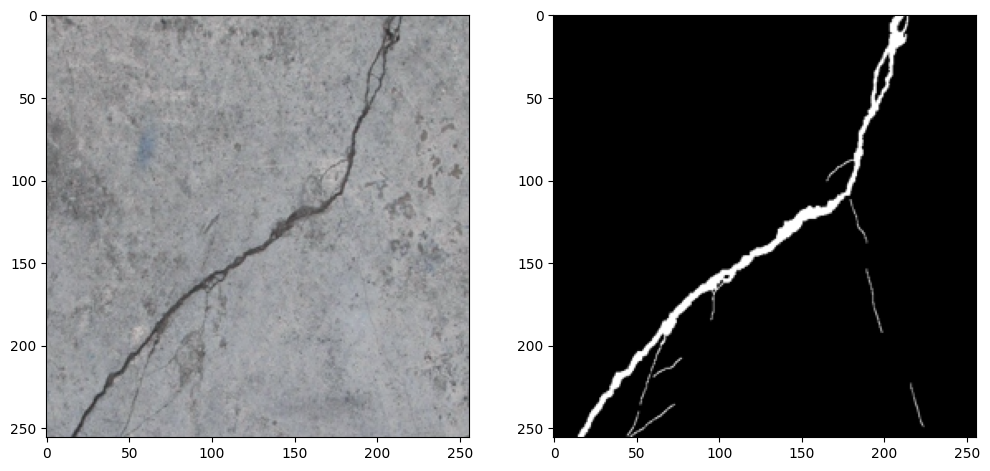

In [6]:
# Print random sample data to check consistency

image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [7]:
# Calculate input shape of the images
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #For Binary Classification
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 8
input_shape=(256, 256, 3)

# **Evaluation Metrics**

In [8]:
#Set Evaluation Metrics and losses
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

# **Define Attention Block and U-Net**

In [9]:
# Convolution block
def conv_block(x, filter_size, size, dropout, batch_norm=True):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

# Set separate block for SiLU in top layer
def conv_block1(x, filter_size, size, dropout, batch_norm=True):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("silu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("silu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


# To calculate attention gate
def repeat_elem(tensor, rep):
    return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def gating_signal(input, out_size, batch_norm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    concat_xg = layers.add([phi_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('relu')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

#U-Net
def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):

    FILTER_NUM = 32 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters


    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers

    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7

    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    # up_32=layers.Conv2DTranspose(64, (3, 3), strides=(2, 2),padding='same')(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)

    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    # up_64=layers.Conv2DTranspose(128, (3, 3), strides=(2, 2),padding='same')(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9

    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    # up_128=layers.Conv2DTranspose(256, (3, 3), strides=(2, 2),padding='same')(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #softmax for multichannel

    # Model
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model



#All Attention U-Net
def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):

    # network structure
    FILTER_NUM = 32 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model

# **Proposed Model**

In [10]:
#Attention (Bottleneck) U-net + SiLU(Top layer)

def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):

    # network structure
    FILTER_NUM = 32 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)
    # Upsampling layers
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM,)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 =conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block1(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model

# **Fit U-Net Model**

In [ ]:
# Fit U-Net model with dataset
model = UNet(input_shape)

model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy',
              metrics=['accuracy', jacard_coef])

print(model.summary())

start1 = datetime.now()
unet_history = model.fit(X_train, y_train,
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    epochs=35)

stop1 = datetime.now()

#Execution time of the model
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)

model.save('U-Net(baseline500).hdf5')

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 32)         0         ['batch_normalization[0][0]

None
Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 32)         0         ['batch_normalization[

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Fit Attention Model**

In [11]:
# Fit Attention Model
att_unet_model = Attention_UNet(input_shape)

att_unet_model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy',
              metrics=['accuracy', jacard_coef])


print(att_unet_model.summary())
start2 = datetime.now()

att_unet_history = att_unet_model.fit(X_train, y_train,
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ),
                    shuffle=False,
                    epochs=35)

stop2 = datetime.now()

#Execution time of the model
execution_time_Att_Unet = stop2-start2
print("Attention UNet execution time is: ", execution_time_Att_Unet)

att_unet_model.save('Proposed_Model.hdf5')

Model: "Attention_UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 32)         0         ['batch_normaliza

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Training and Loss vs Epochs**

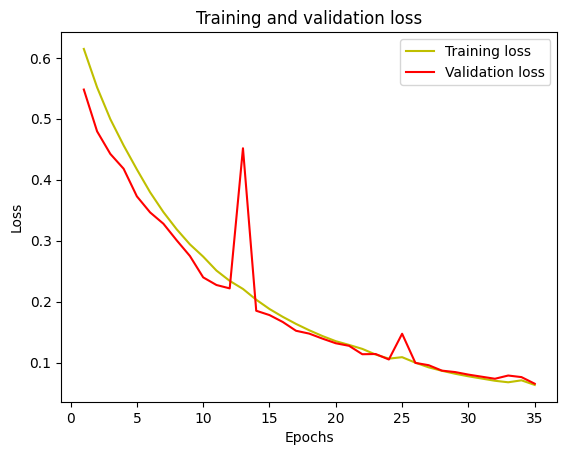

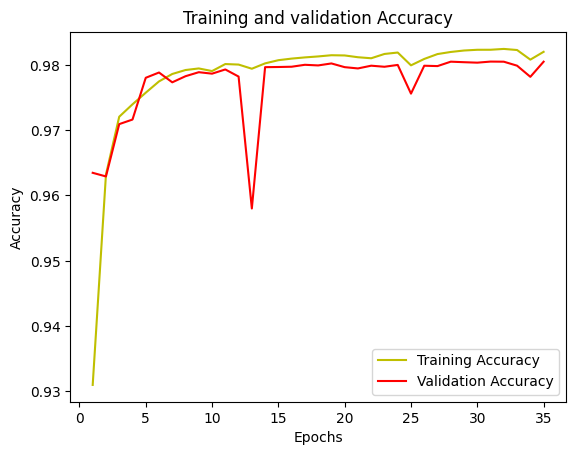

In [12]:
# Evaluation Results

# unet_history_df = pd.DataFrame(unet_history.history)
att_unet_history_df = pd.DataFrame(att_unet_history.history)


# with open('unet_history_df.csv', mode='w') as f:
#     unet_history_df.to_csv(f)

with open('att_unet_history_df.csv', mode='w') as f:
    att_unet_history_df.to_csv(f)

# Check history plots, one model at a time

# history = unet_history
history = att_unet_history


# Plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_validation_lo.pdf')
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_validation_ac.pdf')
plt.show()

# **Load Test Dataset**

In [13]:

# Set test image and mask from a same directory


# Set test image and mask from seperate directory
image_directory = '/content/drive/MyDrive/Segmentation/Dataset/DeepCrack/test/test_img/'
mask_directory = '/content/drive/MyDrive/Segmentation/Dataset/DeepCrack/test/test_lab/'


# Load your new test dataset
SIZE = 256
X_test_new = []  # For new test images
y_test_new = []  # For new test masks

# Load images same as train image
images = sorted([img for img in os.listdir(image_directory) if img.endswith('.jpg')])
masks = sorted([mask for mask in os.listdir(mask_directory) if mask.endswith('.png')])

for image_name in images:
    image = cv2.imread(os.path.join(image_directory, image_name), 1)
    image = Image.fromarray(image)
    image = image.resize((SIZE, SIZE))
    X_test_new.append(np.array(image))

for mask_name in masks:
    mask = cv2.imread(os.path.join(mask_directory, mask_name), 0)
    mask = Image.fromarray(mask)
    mask = mask.resize((SIZE, SIZE))
    y_test_new.append(np.array(mask))

# Normalize images
X_test_new = np.array(X_test_new) / 255.0

# Normalize masks (rescale to 0 to 1)
y_test_new = np.expand_dims(np.array(y_test_new), 3) / 255.0

# **Plot Prediction Results**

1/1 [==============================] - 3s 3s/step


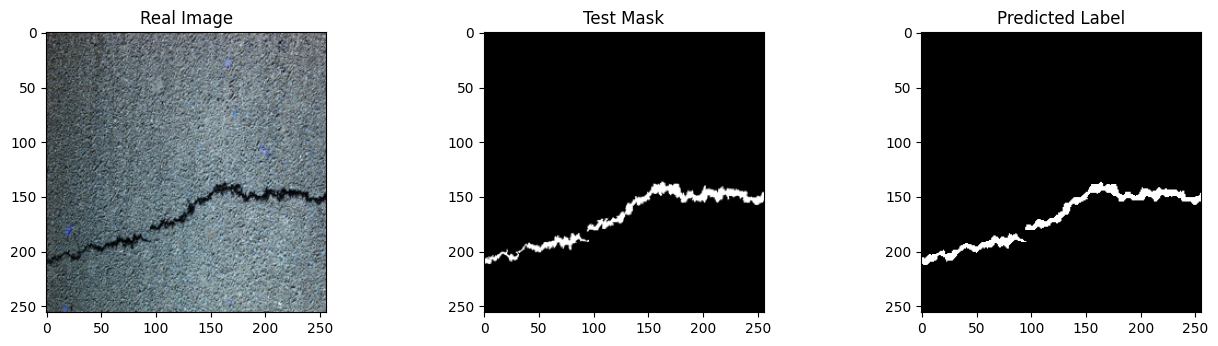

In [14]:
# Load Any Model and Check Results

# model=att_unet_model # To define model

model_path = "/content/Proposed_Model.hdf5" # load any save model

# Load one model at a time for testing.
model = tf.keras.models.load_model(model_path, compile=False)

test_img_number = random.randint(0, X_test_new.shape[0]-1)
test_img = X_test_new[7]
ground_truth=y_test_new[7]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Real Image')
plt.imshow(test_img, cmap='gray')
# plt.savefig('test_image.pdf')
plt.subplot(232)
plt.title('Test Mask')
# plt.savefig('test_mask.pdf')
plt.imshow(ground_truth[:, :, 0], cmap='gray')
plt.subplot(233)
plt.title('Predicted Label')
plt.imshow(prediction, cmap='gray')
plt.savefig('predictionpto97.pdf')
plt.show()

# **Calculate Mean IoU**

In [16]:
# Valculate mean IoU for a Test images
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

IoU_values = []
for img in range(0, X_test_new.shape[0]):
    temp_img = X_test_new[img]
    ground_truth=y_test_new[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)

df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)

Mean IoU = 0.6684898
1/1 [==============================] - 0s 29ms/step
0.67971647
1/1 [==============================] - 0s 29ms/step
0.82177955
1/1 [==============================] - 0s 43ms/step
0.8484856
1/1 [==============================] - 0s 34ms/step
0.72107166
1/1 [==============================] - 0s 32ms/step
0.7886927
1/1 [==============================] - 0s 36ms/step
0.72670496
1/1 [==============================] - 0s 34ms/step
0.6966436
1/1 [==============================] - 0s 30ms/step
0.7955133
1/1 [==============================] - 0s 32ms/step
0.83908623
1/1 [==============================] - 0s 38ms/step
0.6883305
1/1 [==============================] - 0s 36ms/step
0.72223336
1/1 [==============================] - 0s 32ms/step
0.753353
1/1 [==============================] - 0s 36ms/step
0.8578791
1/1 [==============================] - 0s 37ms/step
0.81629217
1/1 [==============================] - 0s 20ms/step
0.81809974
1/1 [==============================] - 0s 

# **For Accuracy, Recall and F1 Score**

In [17]:
# Load libraries for Accuracy, Recall and F1 Score
from sklearn.metrics import precision_score, recall_score, f1_score
accuracies = []
precisions = []
recalls = []
f1_scores = []

for i in range(len(X_test_new)):
    test_img = X_test_new[i]
    ground_truth = y_test_new[i]

    # Prepare the test image for prediction
    test_img_input = np.expand_dims(test_img, 0)

    # Get the prediction from the model for the selected test image
    predicted_mask = (model.predict(test_img_input)[0, :, :, 0] > 0.5).astype(np.uint8)

    # Binarize ground truth and predicted masks
    ground_truth_binary = (ground_truth > 0.5).astype(np.uint8)
    predicted_mask_binary = predicted_mask

    # Calculate accuracy for this single test image
    accuracy = np.mean(predicted_mask_binary == ground_truth_binary[:, :, 0])

    # Calculate precision, recall, and F1-score
    precision = precision_score(ground_truth_binary.flatten(), predicted_mask_binary.flatten())
    recall = recall_score(ground_truth_binary.flatten(), predicted_mask_binary.flatten())
    f1 = f1_score(ground_truth_binary.flatten(), predicted_mask_binary.flatten())

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Calculate the average accuracy for the entire test dataset
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1_score = np.mean(f1_scores)

print("Average Accuracy for the test dataset:", average_accuracy)
print("Average Precision for the test dataset:", average_precision)
print("Average Recall for the test dataset:", average_recall)
print("Average F1 Score for the test dataset:", average_f1_score)

1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 20ms/step
Average Accuracy for the test dataset: 0.9873232298259493
Average Precision for the test dataset: 0.8940627934148566
Average Recall for the test dataset: 0.7708055348773252
Average F1 Score for the test dataset: 0.803218557317747


In [18]:
# Initialize an empty list to store accuracies
accuracies = []

# Iterate through all test images
for i in range(len(X_test_new)):
    test_img = X_test_new[i]
    ground_truth = y_test_new[i]

    # Prepare the test image for prediction
    test_img_input = np.expand_dims(test_img, 0)

    # Get the prediction from the model for the selected test image
    predicted_mask = (model.predict(test_img_input)[0, :, :, 0] > 0.6).astype(np.uint8)

    # Calculate accuracy for this single test image
    accuracy = np.mean(predicted_mask == ground_truth[:, :, 0])

    accuracies.append(accuracy)

# Calculate the average accuracy for the entire test dataset
average_accuracy = np.mean(accuracies)

print("Average Accuracy for the test dataset:", average_accuracy)

1/1 [==============================] - 0s 20ms/step
Average Accuracy for the test dataset: 0.972255916032107


In [19]:
import platform
import multiprocessing

print("System Information:")
print(f"OS: {platform.system()} {platform.release()}")
print(f"CPU: {platform.processor()}")
print(f"Number of CPU cores: {multiprocessing.cpu_count()}")
!nvidia-smi


System Information:
OS: Linux 6.1.58+
CPU: x86_64
Number of CPU cores: 2
Wed Mar 13 19:04:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0              36W /  70W |  10431MiB / 15360MiB |     14%      Default |
|                                         |                      |                  N

# **Calculate GFLOPS**

In [36]:
# Calculate GFLOPs
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

model_path='/content/Proposed_Model.hdf5'
model = tf.keras.models.load_model(model_path, compile=False)
def get_flops(model, batch_size=None):
    if batch_size is None:
        batch_size = 1

    real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                            run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops


# calculating flops
flops = get_flops(model, batch_size = 8)
print(flops)
print(f"FLOPS: {flops / 10 ** 9:.03} G ")

223363989512
FLOPS: 2.23e+02 G 


1/1 [==============================] - 0s 21ms/step
Average Accuracy for the entire test dataset: 0.9729439779675962


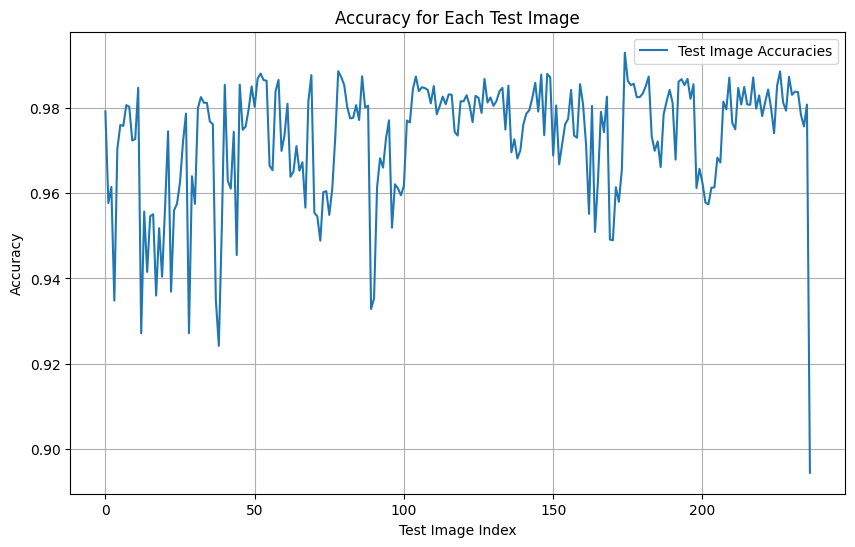

In [25]:
accuracies = []

# Accuracy through all test images
for i in range(len(X_test_new)):
    test_img = X_test_new[i]
    ground_truth = y_test_new[i]

    # Prepare the test image for prediction
    test_img_input = np.expand_dims(test_img, 0)

    predicted_mask = (model.predict(test_img_input)[0, :, :, 0] > 0.5).astype(np.uint8)

    # Calculate accuracy for this single test image
    accuracy = np.mean(predicted_mask == ground_truth[:, :, 0])

    accuracies.append(accuracy)

# Calculate the average accuracy for the entire test dataset
average_accuracy = np.mean(accuracies)

print("Average Accuracy for the entire test dataset:", average_accuracy)

# Plotting the accuracies for each test image
plt.figure(figsize=(10, 6))
plt.plot(accuracies, label='Test Image Accuracies')
plt.xlabel('Test Image Index')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Test Image')
plt.legend()
plt.grid(True)
plt.savefig('test_image_accuracies.pdf')
plt.show()


# **Plot all model's performance for Accuracy and Loss in terms of Epochs**

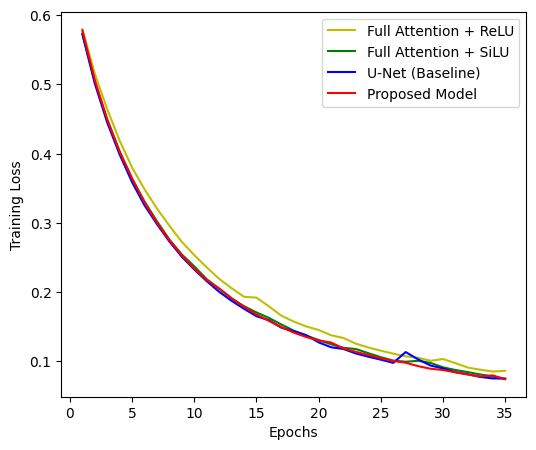

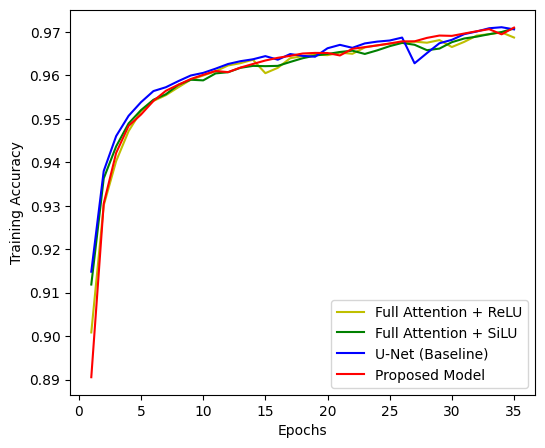

In [ ]:
# Load the history data from CSV files

att_unet_relu_df = pd.read_csv('/content/unet_history_df.csv') # Model
att_silu_unet_history_df = pd.read_csv('/content/proposed.csv')
unet_df = pd.read_csv('/content/att_silu500.csv')
proposed_history_df = pd.read_csv('/content/att_relu.csv')

# Define epochs range based on one of the dataframes
epochs = range(1, len(att_unet_relu_df['loss']) + 1)

# Plot training and validation loss for all models
plt.figure(figsize=(6, 5))
# plt.plot(epochs, unet_history_df['loss'], 'y', label='Model 2 Training Loss')
# plt.plot(epochs, unet_history_df['val_loss'], 'y--', label='UNet Validation Loss')
plt.plot(epochs, att_unet_relu_df['loss'], 'y', label='Full Attention + ReLU')
# plt.plot(epochs, att_unet_history_df['val_loss'], 'b--', label='AttUNet Validation Loss')
plt.plot(epochs, att_silu_unet_history_df['loss'], 'g', label='Full Attention + SiLU')
# plt.plot(epochs, att_res_unet_history_df['val_loss'], 'g--', label='AttResUNet Validation Loss')
plt.plot(epochs, unet_df['loss'], 'b', label='U-Net (Baseline)')
# plt.plot(epochs, att_unet_history_df['val_loss'], 'b--', label='AttUNet Validation Loss')
plt.plot(epochs, proposed_history_df['loss'], 'r', label='Proposed Model')
# plt.plot(epochs, att_res_unet_history_df['val_loss'], 'g--', label='AttResUNet Validation Loss')
# plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.savefig('Prediction_loss.pdf')
plt.show()

# Plot training and validation accuracy for all models
plt.figure(figsize=(6, 5))
# plt.plot(epochs, unet_history_df['accuracy'], 'y', label='Model 2 Training Accuracy')
# plt.plot(epochs, unet_history_df['val_accuracy'], 'y--', label='UNet Validation Accuracy')
plt.plot(epochs, att_unet_relu_df['accuracy'], 'y', label='Full Attention + ReLU')
# plt.plot(epochs, att_unet_history_df['val_accuracy'], 'b--', label='AttUNet Validation Accuracy')
plt.plot(epochs, att_silu_unet_history_df['accuracy'], 'g', label='Full Attention + SiLU')
# plt.plot(epochs, att_res_unet_history_df['val_accuracy'], 'g--', label='AttResUNet Validation Accuracy')
plt.plot(epochs, unet_df['accuracy'], 'b', label='U-Net (Baseline)')
# plt.plot(epochs, att_unet_history_df['val_accuracy'], 'b--', label='AttUNet Validation Accuracy')
plt.plot(epochs, proposed_history_df['accuracy'], 'r', label='Proposed Model')
# plt.plot(epochs, att_res_unet_history_df['val_accuracy'], 'g--', label='AttResUNet Validation Accuracy')
# plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.savefig('prediction_accuracy.pdf')
plt.show()
